# Imports

In [1]:
import sys  
sys.path.insert(1, '..')

In [2]:
from deepview import DeepView
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import splinecam
import seaborn as sns
from tqdm.notebook import tqdm
from src.utils_train import train, val_step, train_one, val_step_one
from sklearn.datasets import make_moons, make_circles,make_classification
from sklearn.model_selection import train_test_split
import matplotlib.colors as mcolors
from matplotlib.collections import PathCollection
from matplotlib.legend_handler import HandlerPathCollection, HandlerLine2D
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import KFold


<unknown>:3: SyntaxWarning: invalid escape sequence '\i'


# REPRODUCIBILITY

In [3]:
seed = 15
torch.manual_seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic = True

# SETUP

In [4]:
TRAIN = True
ONE_TRAIN = False
ONE_NODE_OUT = True

act_func = F.sigmoid if ONE_NODE_OUT else lambda y: F.softmax(y, dim=1)
dir = "results/"
if not os.path.isdir(dir): os.mkdir(dir)
train, val_step = (train_one, val_step_one) if ONE_NODE_OUT else (train, val_step)

In [5]:
def make_dataloader(generator,config, noise=0.05,seed=15, batch_size=128):
    '''
    Generates a dataloader with config, it can run a generator or use make_classification function
    '''    

    if config["name"] == "Spiral":
        X,y = generator(n_samples=config["n_samples"], shuffle=False,
                        noise=noise, random_state=seed)#rotations=.5
    else:
       X, y = make_classification(config["n_samples"], n_features= config["n_features"], n_classes=config["n_classes"], random_state=seed,\
                                  n_informative=config["n_informative"], shift=0,n_redundant=0, n_clusters_per_class=2, class_sep = 2, shuffle=False)
        
    inputs = torch.hstack([
        torch.Tensor(X[:,:]),torch.Tensor(y[...,None])
    ])

    dataloader = torch.utils.data.DataLoader(inputs,
                                             batch_size=batch_size,
                                             pin_memory=True,
                                             shuffle=True)
    return dataloader


def make_spiral(n_samples, shuffle=False, noise=1, random_state=0, rotations=1.5):
  '''
  Make spiral dataset
  '''

  N = n_samples
  pi = rotations*np.pi
  theta = np.sqrt(np.random.rand(N))*2*pi # np.linspace(0,2*pi,100)

  r_a = 2*theta + pi
  data_a = np.array([np.cos(theta)*r_a, np.sin(theta)*r_a]).T
  x_a = data_a + np.random.randn(N,2)*1

  r_b = -2*theta - pi
  data_b = np.array([np.cos(theta)*r_b, np.sin(theta)*r_b]).T
  x_b = data_b + np.random.randn(N,2)*1

  res_a = np.append(x_a, np.zeros((N,1)), axis=1)
  res_b = np.append(x_b, np.ones((N,1)), axis=1)

  res = np.append(res_a, res_b, axis=0)
  np.random.shuffle(res)

  return res[:,:2],res[:,-1]

In [6]:
experiment_config = {"Custom": {"name": "Custom",
                                "n_features":2,
                                "n_samples":2000,
                                "n_classes":2,
                                "n_informative":2},
                     "Spiral":{"name": "Spiral",
                               "n_features":2,
                                "n_samples":10000,
                                "n_classes":2,
                                "n_informative":2},
                     "Three":{"name": "Three",
                              "n_features":3,
                                "n_samples":2000,
                                "n_classes":2,
                                "n_informative":3}}
# Experiment selection
exp_name = "Custom"
select_config = experiment_config[exp_name]
n_features = select_config["n_features"]
n_informative = select_config["n_informative"]
n_classes = select_config["n_classes"]
n_samples = select_config["n_samples"]

In [7]:
# prepare data
# dataloader = make_dataloader(make_moons,10000)
# dataloader = make_dataloader(make_circles,10000)
dataloader = make_dataloader(make_spiral,select_config)

tot_idx = range(n_samples)
train_idx, test_idx = train_test_split(tot_idx, test_size = 0.15, random_state=seed)
X = dataloader.__dict__['dataset'][:,:-1]
y = dataloader.__dict__['dataset'][:,-1]
# Train set
y_train = y[train_idx]
# Test set HOLDOUT SET
y_test =y[test_idx]

Text(0.5, 1.0, 'Data')

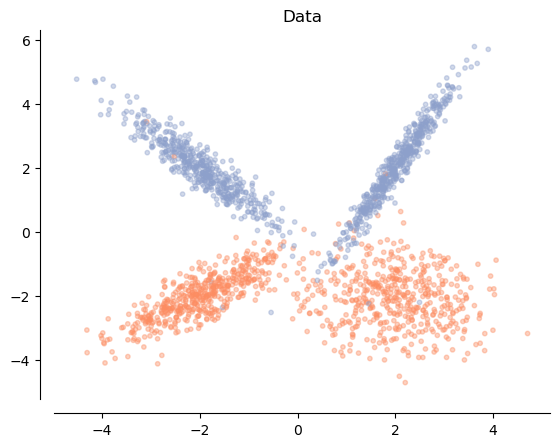

In [8]:
# custom cmap definition
custom_cmap = mcolors.ListedColormap([plt.get_cmap("Set2")(1),plt.get_cmap("Set2")(2)])

# Display dataset
plt.rcParams['figure.dpi'] = 100
fig = plt.figure()
ax = fig.add_subplot(projection=("3d" if n_features == 3 else None))
if n_features == 3: ax.view_init(azim=-40 , elev = 25)
if n_features == 3:
    ax.view_init(azim=-50 , elev = 25)
color = dataloader.__dict__['dataset'][:,-1].numpy().astype(np.int8)
ax.scatter(*dataloader.__dict__['dataset'][:,:-1].numpy().T,
            c = color, s=10, alpha=.4, cmap=custom_cmap)
sns.despine(offset=10)
ax.set_title("Data")

## NEURAL NETWORK

In [9]:
# model definition
width = 10
depth = 5
activation_fn = torch.nn.ReLU ## torch.nn.LeakyReLU
device='cuda'
bias = True

# create model
def get_model():
	layers = [torch.nn.Flatten()]
	for i in range(depth):
		if i == 0:
			layers.append(torch.nn.Linear(np.prod(n_features), width))
			layers.append(activation_fn())
		elif i == depth - 1:
			layers.append(nn.Linear(int(width), 1 if ONE_NODE_OUT else n_classes))
		# elif i == depth - 2:
		#     layers.append(nn.MaxPool1d(2))
		else:
			layers.append(nn.Linear(width, width))
			layers.append(activation_fn())
	return nn.Sequential(*layers).to(device)

model = get_model()

# bias cant be none for splinecam library, hence we separately set it to zero
if not bias:
	for layer in model:
		if hasattr(layer,'bias'):
			layer.bias = torch.nn.Parameter(torch.zeros_like(layer.bias)+1e-6)

In [10]:
model.type

<bound method Module.type of Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=2, out_features=10, bias=True)
  (2): ReLU()
  (3): Linear(in_features=10, out_features=10, bias=True)
  (4): ReLU()
  (5): Linear(in_features=10, out_features=10, bias=True)
  (6): ReLU()
  (7): Linear(in_features=10, out_features=10, bias=True)
  (8): ReLU()
  (9): Linear(in_features=10, out_features=1, bias=True)
)>

# TRAIN

In [11]:
# Single fold train
if ONE_TRAIN:
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.BCEWithLogitsLoss() if ONE_NODE_OUT else nn.CrossEntropyLoss()#nn.BCEWithLogitsLoss()

    epochs = 200
    device = 'cpu'
    model = model.to(device)

    for epoch in tqdm(range(1, epochs + 1)):

        # train step
        val_acc = 0
        model.train()
        total_loss = 0
        for batch_idx, data in enumerate(dataloader, 1):
            model.type(torch.float32)
            # prep data
            
            data,target = data[:,:-1],data[:,-1:]
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(data)

            # calculate loss and perform backprop
            loss = criterion(output, target.view(-1,1) if ONE_NODE_OUT else target.view(-1).long())
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            y_pred_class = F.sigmoid(output).round() if ONE_NODE_OUT else torch.argmax(torch.softmax(output,dim=1),dim=1)
            val_acc += ((y_pred_class.view(-1) == target.flatten().view(-1)).sum().item()/len(target))

        # model.cuda()
        model.train()
        model.type(torch.float32)

        # print loss stats
        print("Epoch: {}, Loss: {}, Acc: {}".format(epoch, total_loss / len(dataloader), val_acc/(batch_idx+1)))   

## CROSS VALIDATION

In [12]:
#generatin the 10 fold data
folds = 10
NUM_EPOCHS = 15
device = "cpu"
if TRAIN and not ONE_TRAIN:
  
	kf = KFold(n_splits=folds)#,random_state=42, shuffle=True

	# Continue the training and validation of the model for all the other folds
	for i, (train_index, test_index) in tqdm(enumerate(kf.split(train_idx))):
		model = get_model().to(device)
		optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
		loss_fn =nn.BCEWithLogitsLoss() if ONE_NODE_OUT else nn.CrossEntropyLoss()

		# Keeping the split
		train_str = "train_"+str(i)
		val_str = "val_"+str(i)

		# Turn train and validation Datasets into DataLoaders
		ds_train = TensorDataset(X[train_idx][train_index].to(device), y_train[train_index].view(-1,1).to(device))
		ds_test = TensorDataset(X[train_idx][test_index].to(device), y_train[test_index].view(-1,1).to(device))
		trainloader = DataLoader(ds_train,batch_size=16,shuffle=True)
		validationloader = DataLoader(ds_test,batch_size=16)

		# Start the timer
		from timeit import default_timer as timer
		start_time = timer()
		# Train model
		model_results = train(model=model,
							train_dataloader=trainloader,
							val_dataloader=validationloader,
							optimizer=optimizer,
							loss_fn=loss_fn,
							epochs=NUM_EPOCHS,
							split=i,
							dir=dir)
		# End the timer and print out how long it took
		end_time = timer()
		print(f"Total training time for split {i}: {end_time-start_time:.3f} seconds")

		# Extract train and validation loss and accuracy at each epoch
		results = dict(list(model_results.items()))

		# Get the loss values of the results dictionary (training and validation)
		train_loss = results["train_loss"]
		val_loss = results["val_loss"]

		# Get the accuracy values of the results dictionary (training and validation)
		train_acc = results["train_acc"]
		val_acc = results["val_acc"]

		# Figure out how many epochs there were
		epochs = range(len(results["train_loss"]))
		
		# Save results in a csv
		results_df = pd.DataFrame(columns= ["train_loss","val_loss","train_acc","val_acc","epochs"])
		results_df["train_loss"] = train_loss
		results_df["val_loss"] = val_loss
		results_df["train_acc"] = train_acc
		results_df["val_acc"] = val_acc
		results_df["epochs"] = epochs
		path = "One_results_df_" if ONE_NODE_OUT else "results_df_"
		results_df_name = f"{dir}/{path}"+str(i)+".csv"
		results_df.to_csv(results_df_name)

0it [00:00, ?it/s]

Epoch: 1 | train_loss: 0.6310 | train_acc: 0.6539 | val_loss: 0.4298 | val_acc: 0.9489
Epoch: 2 | train_loss: 0.2068 | train_acc: 0.9629 | val_loss: 0.0991 | val_acc: 0.9716
Epoch: 4 | train_loss: 0.0804 | train_acc: 0.9775 | val_loss: 0.0801 | val_acc: 0.9773
Total training time for split 0: 0.698 seconds
Epoch: 1 | train_loss: 0.6414 | train_acc: 0.6126 | val_loss: 0.4910 | val_acc: 0.9830
Total training time for split 1: 0.692 seconds
Epoch: 1 | train_loss: 0.6100 | train_acc: 0.6667 | val_loss: 0.4516 | val_acc: 0.9625
Epoch: 2 | train_loss: 0.2275 | train_acc: 0.9697 | val_loss: 0.0847 | val_acc: 0.9852
Total training time for split 2: 0.693 seconds
Epoch: 1 | train_loss: 0.6625 | train_acc: 0.5432 | val_loss: 0.5693 | val_acc: 0.9170
Epoch: 2 | train_loss: 0.3688 | train_acc: 0.9479 | val_loss: 0.1376 | val_acc: 0.9886
Epoch: 3 | train_loss: 0.1181 | train_acc: 0.9733 | val_loss: 0.0575 | val_acc: 0.9943
Total training time for split 3: 0.693 seconds
Epoch: 1 | train_loss: 0.6428

## TRAIN PERFORMANCES

In [13]:
if not ONE_TRAIN:
	results = []
	val_accuracies = np.zeros([10,1])
	path = "One_results_df_" if ONE_NODE_OUT else "results_df_"
	for i in range(folds):
		results.append(pd.read_csv(f"{dir}/{path}{i}.csv"))
		val_accuracies[i] = np.max(results[i]["val_acc"])

	# Get the fold corresponding to the overall best
	index = np.argmax(val_accuracies)


	res = pd.concat(results)
	# res.replace([np.inf, -np.inf], np.nan)
	res = res.map(lambda x: np.nan if x in [np.inf, -np.inf] else x)
	len(results), index, val_accuracies

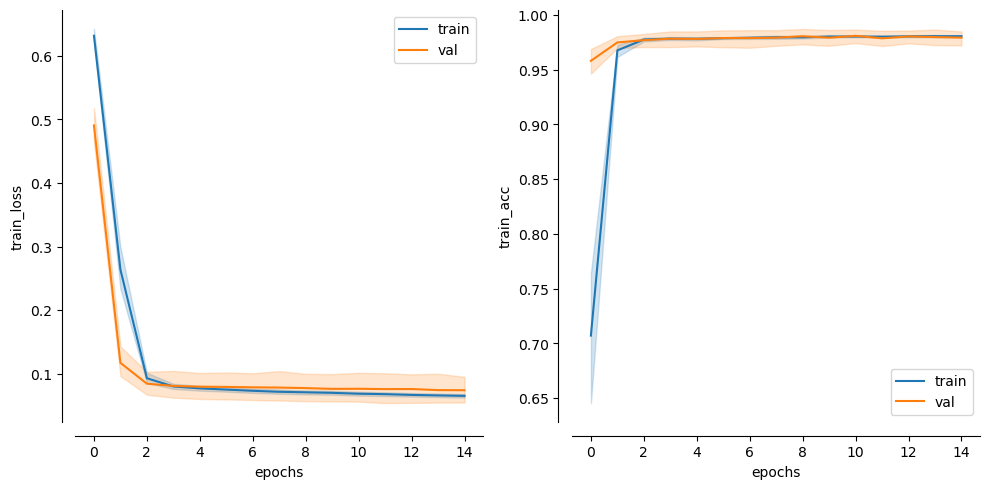

In [14]:
if not ONE_TRAIN:
    fig, axs = plt.subplots(1,2, figsize=(10,5))
    sns.lineplot(data=res, x="epochs", y="train_loss", err_style="band", label="train", ax=axs[0])
    sns.lineplot(data=res, x="epochs", y="val_loss", err_style="band", label="val", ax=axs[0])
    sns.lineplot(data=res, x="epochs", y="train_acc", err_style="band", label="train", ax=axs[1])
    sns.lineplot(data=res, x="epochs", y="val_acc", err_style="band", label="val", ax=axs[1])
    sns.despine(offset=10)
    plt.tight_layout()


In [15]:
if not ONE_TRAIN:
    # Looking across all the best validation accuracies obtained from the ten folds
    val_accuracies = np.zeros([10,1])
    path = "One_results_df_" if ONE_NODE_OUT else "results_df_"
    for i in range(folds):
        results_string = f"{dir}/{path}"+str(i)+".csv"
        val_accuracies[i] = np.max(pd.read_csv(results_string)["val_acc"])

    # Get the fold corresponding to the overall best
    index = np.argmax(val_accuracies)
    index

In [16]:
# Loading the checkpoint
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath,map_location=device)
    model = checkpoint["model"]
    model.load_state_dict(checkpoint["state_dict"])
    for parameter in model.parameters():
        parameter.requires_grad = False
    model.eval()
    return model


In [17]:
# Holdout setup
x_holdout_tensor =  torch.tensor(X[test_idx], dtype=torch.float32).to(device)
y_binary_test_tensor = torch.tensor(y_test).to(device).view(-1,1)
ds_holdout=TensorDataset(x_holdout_tensor,y_binary_test_tensor)
holdout_loader = DataLoader(ds_holdout,batch_size=16)


/tmp/ipykernel_1135773/963514517.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_holdout_tensor =  torch.tensor(X[test_idx], dtype=torch.float32).to(device)
/tmp/ipykernel_1135773/963514517.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_binary_test_tensor = torch.tensor(y_test).to(device).view(-1,1)


In [18]:
if not ONE_TRAIN:
    val_accuracies = np.zeros([10,1])
    ck_path = "One_checkpoint_" if ONE_NODE_OUT else "checkpoint_"
    loss_fn = nn.BCEWithLogitsLoss() if ONE_NODE_OUT else nn.CrossEntropyLoss()
    for i in range(folds):
        model_string = f"{dir}/{ck_path}"+str(i)+".pth"
        model_cp = load_checkpoint(model_string)
        
        val_loss, val_accuracies[i], f1,_= val_step(model=model_cp.to(device),
                    dataloader=holdout_loader,
                    loss_fn=loss_fn)
        print("ACCURACY: ", val_accuracies[i], "F1: ",f1)
        
    index = np.argmax(val_accuracies)
    index

ACCURACY:  [0.97916667] F1:  0.9807692307692307
ACCURACY:  [0.96929825] F1:  0.970873786407767
ACCURACY:  [0.97916667] F1:  0.9807692307692307
ACCURACY:  [0.97916667] F1:  0.9807692307692307
ACCURACY:  [0.98574561] F1:  0.9872611464968153
ACCURACY:  [0.97916667] F1:  0.9807692307692307
ACCURACY:  [0.97916667] F1:  0.9807692307692307
ACCURACY:  [0.97916667] F1:  0.9807692307692307
ACCURACY:  [0.97916667] F1:  0.9807692307692307
ACCURACY:  [0.97916667] F1:  0.9807692307692307


/tmp/ipykernel_1135773/1196447774.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filepath,map_location=device)
/tmp/ipykernel_1135773/1196447774

## Loading best model

In [19]:
if not ONE_TRAIN:
	model_string = f"{dir}/{ck_path}"+str(index)+".pth"
	model_cp = load_checkpoint(model_string)
	model_cp.eval()
	model_cp.to(device)
	loss_fn = nn.CrossEntropyLoss().to(device) 
	print(model_cp)

	val_loss, val_acc, f1,_ = val_step(model=model_cp,
				dataloader=holdout_loader,
				loss_fn=loss_fn)

	print("\nACCURACY: ", val_acc, "\nF1: ",f1)
	model = model_cp


Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=2, out_features=10, bias=True)
  (2): ReLU()
  (3): Linear(in_features=10, out_features=10, bias=True)
  (4): ReLU()
  (5): Linear(in_features=10, out_features=10, bias=True)
  (6): ReLU()
  (7): Linear(in_features=10, out_features=10, bias=True)
  (8): ReLU()
  (9): Linear(in_features=10, out_features=1, bias=True)
)

ACCURACY:  0.9857456140350878 
F1:  0.9872611464968153


/tmp/ipykernel_1135773/1196447774.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filepath,map_location=device)


In [20]:
class_0_data=dataloader.__dict__['dataset'][:,:-1].numpy()[np.where(dataloader.__dict__['dataset'][:,-1].numpy()==0)]
class_1_data=dataloader.__dict__['dataset'][:,:-1].numpy()[np.where(dataloader.__dict__['dataset'][:,-1].numpy()==1)]
# class_2_data=dataloader.__dict__['dataset'][:,:-1].numpy()[np.where(dataloader.__dict__['dataset'][:,-1].numpy()==2)]

In [21]:
def scaling_function(x): 
    return (2000/2-x) / 2000/2

pred_bound = 1/n_classes
def IBS(bs, model, target_class_0,target_class_1, precision = 0.05, iter = False, ret_fail = False, device = 'cpu', noise_mul = 2, path:bool = True, sc_func = scaling_function):
    '''
    Informed Baseline Search with a starting point, and a pool of targets computes a sample of the inner boundary (baseline) of a NN
        
    :param bs: starting point
    :param model: model to be investigated
    :param target_class_0/target_class_1: data of the target pool for class 0 and class 1, can be a single sample for each class
    :param precision: precision of the baseline (.5-precision < predict(bs) < .5+precision needs to be met to consider baseline)
    :param iter: True if target_class_0 and target_class_0 are iterators, otherwise false
    :param ret_fail: True to return 1 if the IBS failed to find a DB sample
    :param device: device
    :param noise_mul: scalar factor to modify the step intensity
    :param path: True to return all pointed computed in the search
    :param sc_func: Scaling function to apply to the step, default `(2000/2-x) / 2000/2`

    
    :returns bs: baseline computed
    :returns temp_bs: path computed if path is false returns the starting point
    :returns fail: (optional) 1 if IBS fails otherwhise 0
    
    '''
    
	# setup
    model = model.to(device)
    if not isinstance(bs, torch.Tensor): bs = torch.tensor(bs, dtype=torch.float32)
    bs = bs.to(device)
    acc=[]
    targets = []
    temp_bs = [bs.cpu().numpy()]
    out = model(bs)
    pred = act_func(out)[0].cpu().detach().numpy()

	# search phase
    while(True):
        acc.append( pred )
        # check bs predict
        if ((pred_bound-precision) < pred ).all() and (pred <(pred_bound+precision)).all():
            if path: temp_bs.append(bs.cpu().numpy())

            return (bs, temp_bs,0, np.stack(targets)) if ret_fail else (bs, temp_bs)
            
		# class target selection 
        softmax_pred = act_func(out)
        pred_idx = softmax_pred.round() if ONE_NODE_OUT else torch.argmax(softmax_pred, dim=1)
        pred_value = softmax_pred if ONE_NODE_OUT else softmax_pred[0,pred_idx]
        
		# target extraction
        try:
            if iter:
                i1_idx = next(target_class_0) if pred_idx else next(target_class_1)
                i1 = [i1_idx]
            else: 
                i1 = target_class_0 if pred_idx else target_class_1
            
        except StopIteration: print("out of data"); break
        targets.append(i1)
        i1 = torch.tensor(i1, dtype=torch.float32).to(device)
        # compute step
        direction = (i1-bs)
        multi = sc_func(len(acc))*noise_mul
        intensity = round(((pred_value-(1-pred_value))/2).item()*multi,5)
        intensity = abs(intensity) #if ONE_NODE_OUT else abs(intensity)
        intensity = np.min([i,intensity])
        weighted_input = direction*intensity
        bs = bs + weighted_input
        
        if path:temp_bs.append(bs.cpu().numpy())
        out = model(bs)
        pred = act_func(out)[0].cpu().detach().numpy()

    return (bs,temp_bs,1, np.stack(targets)) if ret_fail else (bs,temp_bs)


In [22]:
def inference_transf(x):
    """
    Setup input for model 
    """
    return torch.tensor(x, dtype=torch.float32).view(1,n_features)

# IBS

Single run

In [23]:
IBS(inference_transf(class_0_data[0]), model, iter(class_0_data),iter(class_1_data) , precision=0.02,\
                                iter = True, ret_fail=True,device = 'cpu', noise_mul = 1/10, path = False);

/tmp/ipykernel_1135773/3162021925.py:61: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1720538439675/work/torch/csrc/utils/tensor_new.cpp:278.)
  i1 = torch.tensor(i1, dtype=torch.float32).to(device)


### Multi run with multiprocessing lib

In [24]:
def fake_lambda(x):

    return IBS(inference_transf(x), model, iter(class_0_data),iter(class_1_data) , precision=0.001,\
                                iter = True, ret_fail=True,device = 'cpu', noise_mul = 1/10, path = True)

In [25]:
model.type(torch.float32)
all_data = np.concatenate([np.array(class_0_data), np.array(class_1_data)], axis=0)
all_data.shape


(2000, 2)

In [26]:
import multiprocessing
pool = multiprocessing.Pool(15)
model.type(torch.float32)
model.eval()

bs_list=pool.map(fake_lambda, all_data)
lista_map = list(bs_list)
bs_list,bs_path_list = [],[]
fails = []
for item in lista_map:
    fails.append(item[2])
    bs_list.append(item[0][0].cpu().numpy())
    bs_path_list.append(len(np.array(item[1])))
bs_list = np.array(bs_list)
bs_list = bs_list[np.where(np.array(fails) == 0)]

print(f"number of fails: {sum(fails)}\nMean steps taken: {(sum(bs_path_list)/len(bs_path_list)):.2f}")

number of fails: 0
Mean steps taken: 175.12


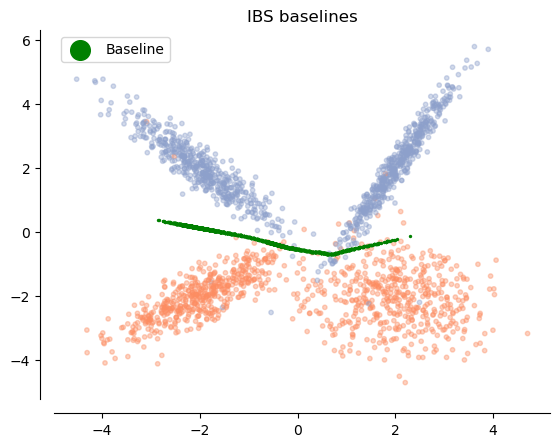

In [27]:
# data + baseline plot
fig = plt.figure()
ax = fig.add_subplot(projection=("3d" if n_features == 3 else None))
if n_features == 3: ax.view_init(azim=-40 , elev = 25)
if n_features == 3:
    ax.view_init(azim=-50 , elev = 25)
color = dataloader.__dict__['dataset'][:,-1].numpy().astype(np.int8)
ax.scatter(*dataloader.__dict__['dataset'][:,:-1].numpy().T,
            c = color, s=10, alpha=.4, cmap=custom_cmap)


bs_arr = np.array(bs_list)
ax.scatter(*bs_arr.T, zorder=10000000000, c='g', s=2, label="Baseline")

sns.despine(offset=10)
ax.set_title("IBS baselines")
ax.legend(*ax.get_legend_handles_labels(),markerscale=10)

# SPLINECAM

In [28]:
if n_features == 2:
    xlow,ylow= dataloader.__dict__['dataset'][:,:-1].min(0)[0].numpy()
    xhigh,yhigh = dataloader.__dict__['dataset'][:,:-1].max(0)[0].numpy()

    # ROI square domain at the input space
    
    domain = torch.tensor([
        [xlow,ylow],
        [xlow,yhigh],
        [xhigh,yhigh],
        [xhigh,ylow,],
        [xlow,ylow],
        
    ])

    T  = torch.eye(3)[:-1]
    # from adjustText import adjust_text
    model.cpu()
    model.eval()
    model.type(torch.float64)

    print('Wrapping model with SplineCam...')

    NN = splinecam.wrappers.model_wrapper(
        model,
        input_shape=(1,n_features),
        T = T,
        dtype = torch.float64,
        device = 'cpu'
    )

    # check .forward() and matmul operation equivalence

    flag =  NN.verify()
    assert flag

    # specify level set for output neuron, for db visualization
    thresh = 0.
    NN.layers[-1].Ab[:,-1] = NN.layers[-1].Ab[:,-1] + thresh

    print(domain.shape)
    # get partitions
    out_cyc,endpoints,Abw = splinecam.compute.get_partitions_with_db(domain,T,NN)


Wrapping model with SplineCam...
Wrapping layer 0...
Wrapping layer 1...
Wrapping layer 2...
Wrapping layer 3...
Wrapping layer 4...
Wrapping layer 5...
Wrapping layer 6...
Wrapping layer 7...
Wrapping layer 8...
Wrapping layer 9...
torch.Size([5, 2])
Finding regions from first layer graph


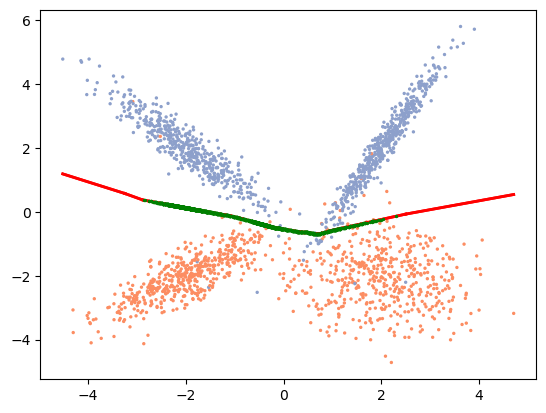

In [29]:
# data + baselines + SplineCAM partition plot
if n_features == 2:
    plt.rcParams['figure.dpi'] = 100
    fig, ax = plt.subplots()
    for each in endpoints:
        if each is not None:
            ax.plot(each[:,0],each[:,1],c='r',zorder=1000000000,linewidth=2)

    texts = []
    g_pred=[]
    k_pred=[]
    model.eval()
    for each in endpoints:
        if each is not None:
            ax.plot(each[:,0],each[:,1],c='r',zorder=1000000000,linewidth=2, alpha=1)
            


    ax.scatter(*dataloader.__dict__['dataset'][:,:-1].numpy().T,
                c = dataloader.__dict__['dataset'][:,-1].numpy(), s=2,
                cmap = custom_cmap)
    ax.scatter(*bs_arr[:,:n_features].T, zorder=10000000000, c='g', s=2, alpha=1)


# DeepView

In [30]:
# softmax operation to use in pred_wrapper
softmax = act_func 
to_deep_len = 1000 # number of samples computed by class (double for baseline)
model.type(torch.float32)
device = "cpu"
model.to(device)

# this is the prediction wrapper, it encapsulates the call to the model
# and does all the casting to the appropriate datatypes
def pred_wrapper(x):
    with torch.no_grad():
        x = np.array(x, dtype=np.float32)
        tensor = torch.from_numpy(x).to(device)
        logits = model(tensor)
        probabilities = act_func(logits).cpu().numpy()
    return probabilities


# the classes in the dataset to be used as labels in the plots
classes = (0,1)
X = np.concatenate((class_0_data[:to_deep_len], class_1_data[:to_deep_len],np.array(bs_arr).reshape(-1,n_features)[:to_deep_len*2]), axis=0).reshape(-1,1,n_features)
Y = np.zeros(X.shape[0])
Y[to_deep_len:] = 1

# DeepView Parameters 
batch_size = 512
max_samples = X.shape[0]
data_shape = (1,n_features)
lam = .65 # default parameter
title = f'{n_features} Features'

deepview = DeepView.DeepView(pred_wrapper, classes, max_samples, batch_size, 
                    data_shape, lam=lam, title=title, cmap="Set2")
model.type(torch.float32)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=2, out_features=10, bias=True)
  (2): ReLU()
  (3): Linear(in_features=10, out_features=10, bias=True)
  (4): ReLU()
  (5): Linear(in_features=10, out_features=10, bias=True)
  (6): ReLU()
  (7): Linear(in_features=10, out_features=10, bias=True)
  (8): ReLU()
  (9): Linear(in_features=10, out_features=1, bias=True)
)

DeepView computation

In [31]:
t0 = time.time()
deepview.add_samples(X, Y.reshape(-1))
print('Time to calculate visualization for %d samples: %.2f sec' % (X.shape[0], time.time() - t0))

Distance calculation 19.98 %
Distance calculation 39.96 %
Distance calculation 59.94 %
Distance calculation 79.92 %
Distance calculation 99.90 %
Embedding samples ...


/data/users/cmorasso/miniconda3/envs/BSA_env/lib/python3.12/site-packages/umap/umap_.py:1858: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/data/users/cmorasso/miniconda3/envs/BSA_env/lib/python3.12/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Computing decision regions ...
Time to calculate visualization for 3999 samples: 98.37 sec


In [32]:
def update(handle, orig):
	"""
	Function to update DeepView plot, altering the alpha
	"""
	handle.update_from(orig)
	handle.set_alpha(1)

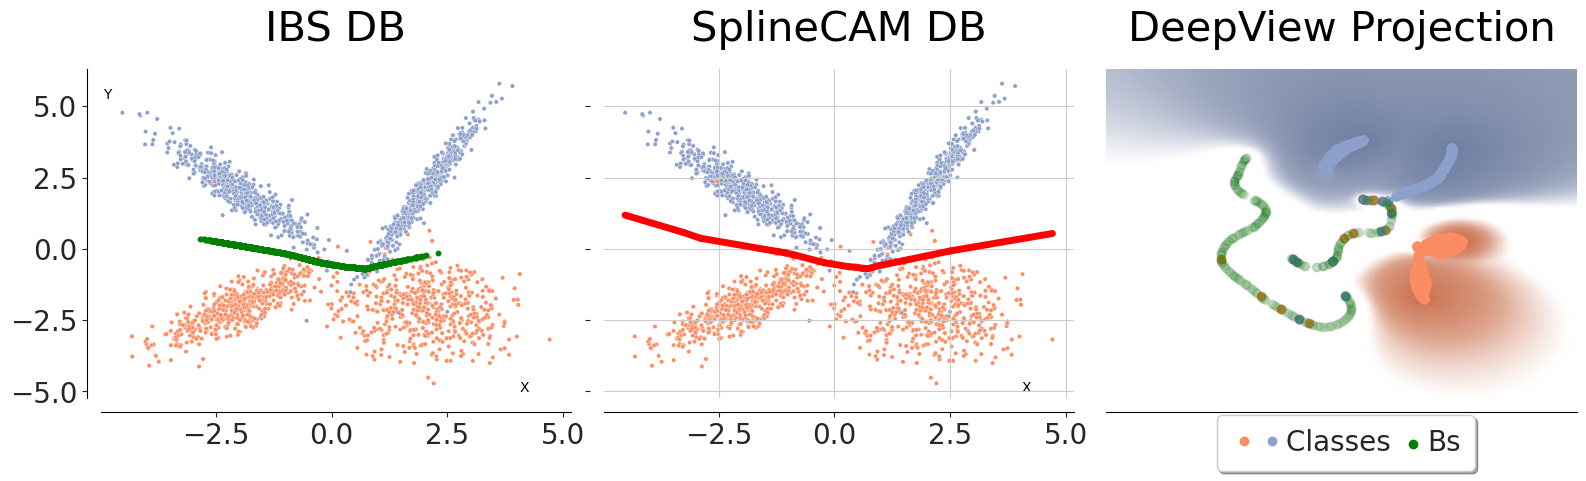

In [33]:
if n_features == 2:
  cols=["X","Y","label"]
  fig, ((ax0,ax1,ax2)) = plt.subplots(1,3, figsize=(16,5));
  sns.set_style("white")

  rc = {
        'figure.dpi': 500,
        'axes.facecolor':'white',
        'axes.grid' : True,
        'grid.color': '.8',
        'font.size' : 20,
		'axes.titlesize': 30,   # fontsize of the axes title
		'axes.labelsize': "medium",  # fontsize of the x any y labels
		'font.size' : 20,
		'axes.titlepad':20}
  plt.rcParams.update(rc)
  custom_cmap = mcolors.ListedColormap([plt.get_cmap("Set2")(1),plt.get_cmap("Set2")(2)])

  deepview.show(baseline = True, last = to_deep_len*2 ,bs_color = 'g', fig=fig, ax=ax2, alpha_bs = .01)
  df = pd.DataFrame(dataloader.__dict__['dataset'].numpy(), columns=cols)
  if n_features == 2:
    sns.scatterplot(df, x="X",y="Y", hue="label", s=10, ax=ax0, palette=sns.color_palette("Set2")[1:3])
    sns.scatterplot(df, x="X",y="Y", hue="label" ,s=10, ax=ax1, palette=sns.color_palette("Set2")[1:3])

  ax0.scatter(*bs_arr[:,:n_features].T, zorder=10000000000, c='g', s=10, alpha=1)

  ax1.set_xlim(ax0.get_xlim())
  ax1.set_ylim(ax0.get_ylim())
  ax1.set_yticklabels([])
  ax1.set_ylabel("")

  for each in endpoints:
      if each is not None:
          ax1.plot(each[:,0],each[:,1],c='r',zorder=1000000000,linewidth=5, alpha=1)
  
  ax0.legend([],frameon=False)
  ax1.legend([],frameon=False)
  ax0.set_title("IBS DB")
  ax1.set_title("SplineCAM DB")
  ax2.set_title("DeepView Projection")
  sns.despine(offset=10, trim=False)
  sns.despine(ax=ax1, top=True, right=True, left=True, bottom=False, offset=10, trim=False)
  sns.despine(ax=ax2, top=True, right=False, left=True, bottom=False, offset=10, trim=False)
  
  ax2.set_xticks([])
  ax2.set_yticks([])
  ax2.set_xticklabels([])
  ax2.set_yticklabels([])
  ax2.set_xlabel("")
  ax2.set_ylabel("")

  h, l = ax2.get_legend_handles_labels()
  
  fig.legend(handles=h, handler_map={PathCollection : HandlerPathCollection(update_func= update),\
    plt.Line2D : HandlerLine2D(update_func = update)},\
      labels=["","Classes ", "Bs"], loc='lower center',  bbox_to_anchor=[0.837, -0.01],
      fancybox=True, shadow=True, ncol=3, fontsize="medium",handlelength=1,borderpad=0.5, handletextpad=0.,columnspacing=0)
  ax2.legend([],frameon=False)
  ax0.set_ylabel("Y", rotation='horizontal', y=0.90, labelpad=-70)
  ax0.set_xlabel("X", rotation='horizontal', x =0.90, labelpad=-50)
  ax1.set_xlabel("X", rotation='horizontal', x=0.90, labelpad=-50)
  ax.grid(True);ax1.grid(True)
  plt.tight_layout()
  


## Umap

In [34]:
import umap
if n_features == 3:
    in_data = np.concatenate([class_0_data,class_1_data])
    labels = np.zeros(in_data.shape[0]+bs_arr.shape[0])
    labels[len(class_0_data):] = 1
    labels[len(class_0_data)+len(class_1_data):] = 2

    reducer = umap.UMAP(50,random_state=seed, init="pca")
    reducer.fit(np.concatenate([in_data,bs_arr]))

    embedding = reducer.transform(np.concatenate([in_data, bs_arr]))

In [35]:

if n_features == 3:
    fig, ((ax0,ax2)) = plt.subplots(1,2, figsize=(20,10)); cols=["X","Y", "Z","label"]
    sns.set_style("white")

    rc = {
        'figure.dpi': 500,
        'figure.figsize':(16,8),
        'axes.facecolor':'white',
        'axes.grid' : True,
        'grid.color': '.8',
        'axes.titlesize': 30,   # fontsize of the axes title
        'axes.labelsize': "medium",  # fontsize of the x any y labels
        'font.size' : 20,
        'axes.titlepad':20}
    plt.rcParams.update(rc)
    custom_cmap = mcolors.ListedColormap([plt.get_cmap("Set2")(1),plt.get_cmap("Set2")(2)])

    deepview.show(baseline = True, last = to_deep_len*2 ,bs_color = 'g', fig=fig, ax=ax2, alpha_bs=0.05)
    df = pd.DataFrame(dataloader.__dict__['dataset'].numpy(), columns=cols)

    ax0.scatter(embedding[:len(in_data), 0], embedding[:len(in_data), 1], c=labels[:len(in_data)], \
                cmap= mcolors.ListedColormap([plt.get_cmap("Set2")(1),plt.get_cmap("Set2")(2)]), s=5)
    ax0.scatter(embedding[len(in_data):, 0], embedding[len(in_data):, 1], c=labels[len(in_data):], \
                cmap= mcolors.ListedColormap(["green"]), s=5, alpha=.5)


    ax0.legend([],frameon=False)

    t0 = ax0.set_title("UMAP projection")

    ax2.set_title("DeepView Projection")
    sns.despine(offset=10, trim=False)

    sns.despine(ax=ax2, top=True, right=False, left=False, bottom=False, offset=10, trim=False)

    ax2.set_xticks([])
    ax2.set_yticks([])
    ax0.set_xticks([])
    ax0.set_yticks([])
    ax2.set_xticklabels([])
    ax2.set_yticklabels([])
    ax2.set_xlabel("")
    ax2.set_ylabel("")
    h,l = ax2.get_legend_handles_labels()
    ax2.legend([],frameon=False)
    fig.legend(handles=h, handler_map={PathCollection : HandlerPathCollection(update_func= update),\
                                                    plt.Line2D : HandlerLine2D(update_func = update)},\
                labels=["","Classes ", "Bs"], loc='lower center',  bbox_to_anchor=[0.41, +0.02],
                fancybox=True, shadow=True, ncol=3, fontsize="medium",handlelength=1,borderpad=0.5, handletextpad=0.,columnspacing=0)

    plt.tight_layout()
